In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture

from clusterless import preprocess
from clusterless import decoder
from clusterless import viz

In [2]:
pid = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_009/2020-02-27/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_009'

In [3]:
rois = [roi.lower() for roi in ['PO', 'LP', 'DG', 'CA1', 'VIS']]

In [4]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
motion_energy, _, wheel_speed, _, _, _ = preprocess.preprocess_dynamic_behaviors(behave_dict)

decode all regions

In [5]:
sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=True,
    triage=False
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times_sorted = sorted[:,0]
spike_clusters = sorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times_sorted, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
1st trial stim on time: 40.81, last trial stim on time 2252.10
sorted neural data shape: (230, 465, 30)


In [6]:
windowed_sorted_neural_data, half_window_size, n_windows = decoder.sliding_window(
    sorted_neural_data, 
    n_trials,
    window_size = 7
)

In [7]:
windowed_wheel_speed = wheel_speed[:,half_window_size:n_windows].reshape(-1,1)
windowed_motion_energy = motion_energy[:,half_window_size:n_windows].reshape(-1,1)

dynamic_behaviors = {
    'motion energy': windowed_motion_energy,
    'wheel speed': windowed_wheel_speed
}

In [8]:
cv_r2s, cv_rmses, cv_ids, cv_obs, cv_preds = decoder.cv_decode_dynamic(
    windowed_sorted_neural_data,
    windowed_motion_energy,
    n_trials,
    'motion energy'
)

motion energy fold 1 test r2: 0.684 rmse: 7.402
motion energy fold 2 test r2: 0.689 rmse: 7.237
motion energy fold 3 test r2: 0.659 rmse: 7.978
motion energy fold 4 test r2: 0.622 rmse: 8.250
motion energy fold 5 test r2: 0.699 rmse: 6.949
motion energy mean of 5-fold cv r2: 0.671 rmse: 7.563
motion energy sd of 5-fold cv r2: 0.028 rmse: 0.480


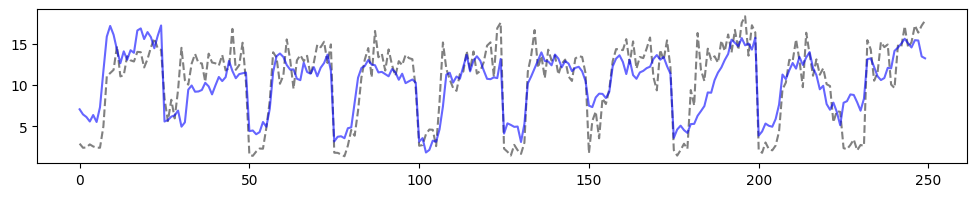

In [9]:
plt.figure(figsize=(12, 2))
plt.plot(np.hstack([cv_obs[0][i] for i in range(0, 50, 5)]), c='gray', linestyle='dashed', label='observed');
plt.plot(np.hstack([cv_preds[0].reshape(-1, 25)[i] for i in range(0, 50, 5)]), c='blue', alpha=.6, label='predicted');

In [10]:
cv_r2s, cv_rmses, cv_ids, cv_obs, cv_preds = decoder.cv_decode_dynamic(
    windowed_sorted_neural_data,
    windowed_wheel_speed,
    n_trials,
    'wheel speed'
)

wheel speed fold 1 test r2: 0.513 rmse: 0.647
wheel speed fold 2 test r2: 0.487 rmse: 0.600
wheel speed fold 3 test r2: 0.396 rmse: 0.872
wheel speed fold 4 test r2: 0.436 rmse: 0.827
wheel speed fold 5 test r2: 0.542 rmse: 0.522
wheel speed mean of 5-fold cv r2: 0.475 rmse: 0.694
wheel speed sd of 5-fold cv r2: 0.053 rmse: 0.134


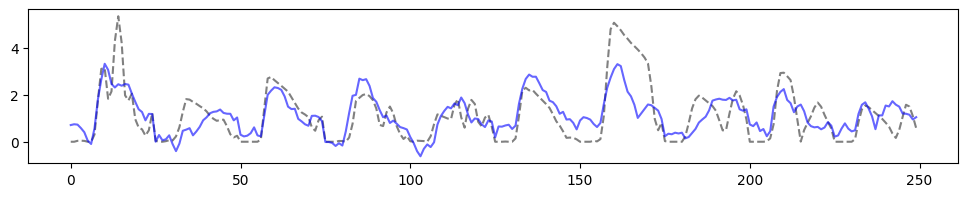

In [11]:
plt.figure(figsize=(12, 2))
plt.plot(np.hstack([cv_obs[0][i] for i in range(0, 50, 5)]), c='gray', linestyle='dashed', label='observed');
plt.plot(np.hstack([cv_preds[0].reshape(-1, 25)[i] for i in range(0, 50, 5)]), c='blue', alpha=.6, label='predicted');

In [8]:
# unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
#     pid=pid, 
#     trial_data_path=trial_data_path,
#     neural_data_path=neural_data_path,
#     behavior_data_path=behavior_data_path,
#     keep_active_trials=True, 
#     roi='all',
#     kilosort=False,
#     triage=False
# )

n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times_unsorted = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times_unsorted, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=False
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (230, 374, 30)


In [9]:
windowed_thresholded_neural_data, half_window_size, n_windows = decoder.sliding_window(
    thresholded_neural_data, 
    n_trials,
    window_size = 7
)

In [14]:
cv_r2s, cv_rmses, cv_ids, cv_obs, cv_preds = decoder.cv_decode_dynamic(
    windowed_thresholded_neural_data,
    windowed_motion_energy,
    n_trials,
    'motion energy'
)

motion energy fold 1 test r2: 0.655 rmse: 8.070
motion energy fold 2 test r2: 0.669 rmse: 7.706
motion energy fold 3 test r2: 0.638 rmse: 8.486
motion energy fold 4 test r2: 0.595 rmse: 8.839
motion energy fold 5 test r2: 0.672 rmse: 7.577
motion energy mean of 5-fold cv r2: 0.646 rmse: 8.136
motion energy sd of 5-fold cv r2: 0.028 rmse: 0.473


In [15]:
cv_r2s, cv_rmses, cv_ids, cv_obs, cv_preds = decoder.cv_decode_dynamic(
    windowed_thresholded_neural_data,
    windowed_wheel_speed,
    n_trials,
    'wheel speed'
)

wheel speed fold 1 test r2: 0.513 rmse: 0.646
wheel speed fold 2 test r2: 0.461 rmse: 0.631
wheel speed fold 3 test r2: 0.371 rmse: 0.908
wheel speed fold 4 test r2: 0.428 rmse: 0.839
wheel speed fold 5 test r2: 0.526 rmse: 0.541
wheel speed mean of 5-fold cv r2: 0.460 rmse: 0.713
wheel speed sd of 5-fold cv r2: 0.057 rmse: 0.138


In [10]:
gmm_name = '../pretrained/danlab/Subjects/DY_009/kilosort_localizations/init_max_chan_gmm'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
loaded_gmm = GaussianMixture(n_components=len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

spike_labels = []
spike_probs = []
offset = 100_000
for i in range(5):
    print(f'loading batch {i+1} ...')
    spike_labels.extend(loaded_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(loaded_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times_unsorted, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30,
    regional=False
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

loading batch 1 ...
loading batch 2 ...
loading batch 3 ...
loading batch 4 ...
loading batch 5 ...
clusterless neural data shape: (230, 311, 30)


In [11]:
windowed_clusterless_neural_data, half_window_size, n_windows = decoder.sliding_window(
    clusterless_neural_data, 
    n_trials,
    window_size = 7
)

In [19]:
cv_r2s, cv_rmses, cv_ids, cv_obs, cv_preds = decoder.cv_decode_dynamic(
    windowed_clusterless_neural_data,
    windowed_motion_energy,
    n_trials,
    'motion energy'
)

motion energy fold 1 test r2: 0.671 rmse: 7.691
motion energy fold 2 test r2: 0.675 rmse: 7.570
motion energy fold 3 test r2: 0.652 rmse: 8.162
motion energy fold 4 test r2: 0.616 rmse: 8.382
motion energy fold 5 test r2: 0.698 rmse: 6.984
motion energy mean of 5-fold cv r2: 0.662 rmse: 7.758
motion energy sd of 5-fold cv r2: 0.027 rmse: 0.488


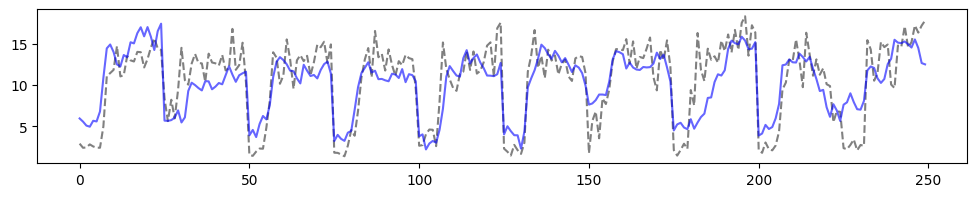

In [20]:
plt.figure(figsize=(12, 2))
plt.plot(np.hstack([cv_obs[0][i] for i in range(0, 50, 5)]), c='gray', linestyle='dashed', label='observed');
plt.plot(np.hstack([cv_preds[0].reshape(-1, 25)[i] for i in range(0, 50, 5)]), c='blue', alpha=.6, label='predicted');

In [21]:
cv_r2s, cv_rmses, cv_ids, cv_obs, cv_preds = decoder.cv_decode_dynamic(
    windowed_clusterless_neural_data,
    windowed_wheel_speed,
    n_trials,
    'wheel speed'
)

wheel speed fold 1 test r2: 0.522 rmse: 0.635
wheel speed fold 2 test r2: 0.470 rmse: 0.621
wheel speed fold 3 test r2: 0.394 rmse: 0.874
wheel speed fold 4 test r2: 0.427 rmse: 0.841
wheel speed fold 5 test r2: 0.549 rmse: 0.515
wheel speed mean of 5-fold cv r2: 0.472 rmse: 0.697
wheel speed sd of 5-fold cv r2: 0.057 rmse: 0.138


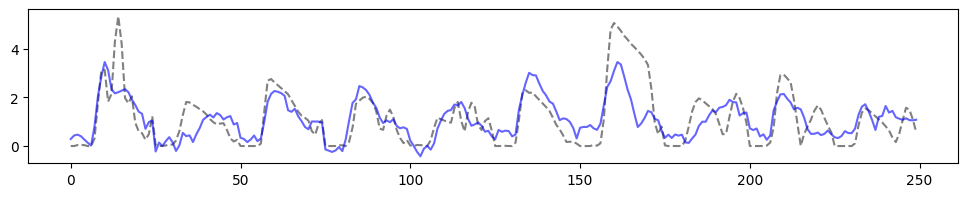

In [22]:
plt.figure(figsize=(12, 2))
plt.plot(np.hstack([cv_obs[0][i] for i in range(0, 50, 5)]), c='gray', linestyle='dashed', label='observed');
plt.plot(np.hstack([cv_preds[0].reshape(-1, 25)[i] for i in range(0, 50, 5)]), c='blue', alpha=.6, label='predicted');

In [12]:
neural_data_dict = {
    'sorted': windowed_sorted_neural_data,
    'thresholded': windowed_thresholded_neural_data,
    'clusterless': windowed_clusterless_neural_data
} 

In [13]:
all_decode_results = {'motion energy': dict(), 'wheel speed': dict()}

for behave_type in all_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type}:')
        decode_results = decoder.cv_decode_dynamic(
            neural_data_dict[data_type], 
            dynamic_behaviors[behave_type], 
            n_trials,
            behave_type=behave_type, 
            n_folds=5, 
            seed=seed
        )
        all_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{save_path}/kilosort_localizations/dynamic_behaviors/all_decode_results.npy', all_decode_results)

sorted:
motion energy fold 1 test r2: 0.684 rmse: 7.402
motion energy fold 2 test r2: 0.689 rmse: 7.237
motion energy fold 3 test r2: 0.659 rmse: 7.978
motion energy fold 4 test r2: 0.622 rmse: 8.250
motion energy fold 5 test r2: 0.699 rmse: 6.949
motion energy mean of 5-fold cv r2: 0.671 rmse: 7.563
motion energy sd of 5-fold cv r2: 0.028 rmse: 0.480
thresholded:
motion energy fold 1 test r2: 0.655 rmse: 8.070
motion energy fold 2 test r2: 0.669 rmse: 7.706
motion energy fold 3 test r2: 0.638 rmse: 8.486
motion energy fold 4 test r2: 0.595 rmse: 8.839
motion energy fold 5 test r2: 0.672 rmse: 7.577
motion energy mean of 5-fold cv r2: 0.646 rmse: 8.136
motion energy sd of 5-fold cv r2: 0.028 rmse: 0.473
clusterless:
motion energy fold 1 test r2: 0.670 rmse: 7.729
motion energy fold 2 test r2: 0.670 rmse: 7.671
motion energy fold 3 test r2: 0.655 rmse: 8.089
motion energy fold 4 test r2: 0.614 rmse: 8.427
motion energy fold 5 test r2: 0.698 rmse: 6.977
motion energy mean of 5-fold cv r2

decode brain regions

In [51]:
roi = rois[4]
print(roi)

vis


In [52]:
sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi=roi,
    kilosort=True,
    triage=False
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times_sorted = sorted[:,0]
spike_clusters = sorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times_sorted, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
1st trial stim on time: 40.81, last trial stim on time 2252.10
found 29 neurons in region vis ...
found 40 channels in region vis ...
sorted neural data shape: (230, 29, 30)


In [53]:
windowed_sorted_neural_data, half_window_size, n_windows = decoder.sliding_window(
    sorted_neural_data, 
    n_trials,
    window_size = 7
)

In [54]:
# unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
#     pid=pid, 
#     trial_data_path=trial_data_path,
#     neural_data_path=neural_data_path,
#     behavior_data_path=behavior_data_path,
#     keep_active_trials=True, 
#     roi=roi,
#     kilosort=False,
#     triage=False
# )

n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times_unsorted = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times_unsorted, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=True
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (230, 15, 30)


In [55]:
windowed_thresholded_neural_data, half_window_size, n_windows = decoder.sliding_window(
    thresholded_neural_data, 
    n_trials,
    window_size = 7
)

In [56]:
gmm_name = '../pretrained/danlab/Subjects/DY_009/kilosort_localizations/init_max_chan_gmm'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
loaded_gmm = GaussianMixture(n_components=len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

spike_labels = loaded_gmm.predict(spike_features)
spike_probs = loaded_gmm.predict_proba(spike_features)

clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times_unsorted, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30,
    regional=True
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (230, 30, 30)


In [57]:
windowed_clusterless_neural_data, half_window_size, n_windows = decoder.sliding_window(
    clusterless_neural_data, 
    n_trials,
    window_size = 7
)

In [58]:
neural_data_dict = {
    'sorted': windowed_sorted_neural_data,
    'thresholded': windowed_thresholded_neural_data,
    'clusterless': windowed_clusterless_neural_data
} 

In [59]:
regional_decode_results = {'motion energy': dict(), 'wheel speed': dict()}

for behave_type in regional_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type}:')
        decode_results = decoder.cv_decode_dynamic(
            neural_data_dict[data_type], 
            dynamic_behaviors[behave_type], 
            n_trials,
            behave_type=behave_type, 
            n_folds=5,
            seed=seed
        )
        regional_decode_results[behave_type].update({data_type: decode_results})
np.save(f'{save_path}/kilosort_localizations/dynamic_behaviors/{roi}_decode_results.npy', regional_decode_results)

sorted:
motion energy fold 1 test r2: 0.433 rmse: 13.270
motion energy fold 2 test r2: 0.449 rmse: 12.819
motion energy fold 3 test r2: 0.415 rmse: 13.701
motion energy fold 4 test r2: 0.394 rmse: 13.221
motion energy fold 5 test r2: 0.402 rmse: 13.806
motion energy mean of 5-fold cv r2: 0.419 rmse: 13.363
motion energy sd of 5-fold cv r2: 0.020 rmse: 0.357
thresholded:
motion energy fold 1 test r2: 0.392 rmse: 14.229
motion energy fold 2 test r2: 0.409 rmse: 13.751
motion energy fold 3 test r2: 0.380 rmse: 14.530
motion energy fold 4 test r2: 0.337 rmse: 14.483
motion energy fold 5 test r2: 0.364 rmse: 14.706
motion energy mean of 5-fold cv r2: 0.376 rmse: 14.340
motion energy sd of 5-fold cv r2: 0.025 rmse: 0.331
clusterless:
motion energy fold 1 test r2: 0.413 rmse: 13.740
motion energy fold 2 test r2: 0.450 rmse: 12.795
motion energy fold 3 test r2: 0.417 rmse: 13.655
motion energy fold 4 test r2: 0.345 rmse: 14.302
motion energy fold 5 test r2: 0.423 rmse: 13.332
motion energy mea

plotting

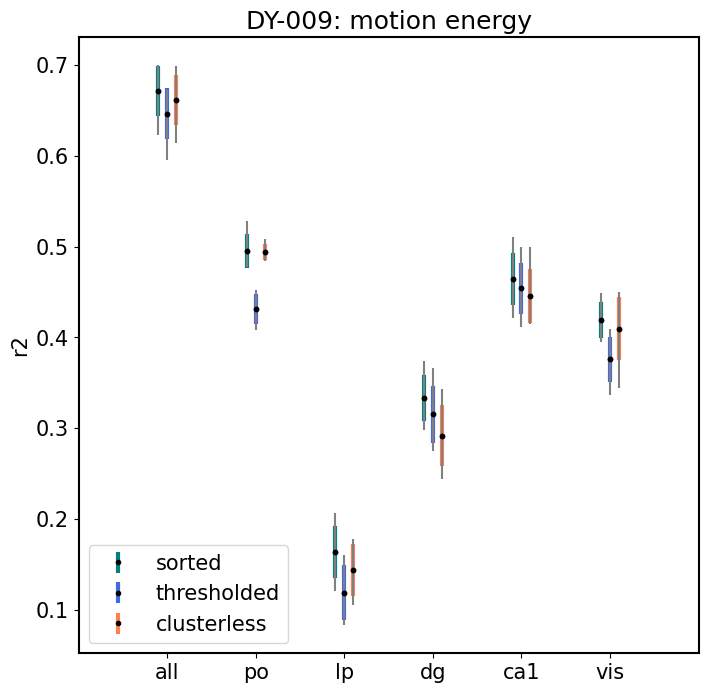

In [65]:
viz.plot_compare_decoder_barplots(
    save_path + '/kilosort_localizations/dynamic_behaviors',
    'motion energy', 
    'r2', 
    rois, 
    n_folds=5, 
    add_smooth=False, 
    figure_size=(8,8), 
    font_size=15, 
    title='DY-009: motion energy',
    save_fig=True,
    fig_path='../saved_figs/danlab/Subjects/DY_009',
)

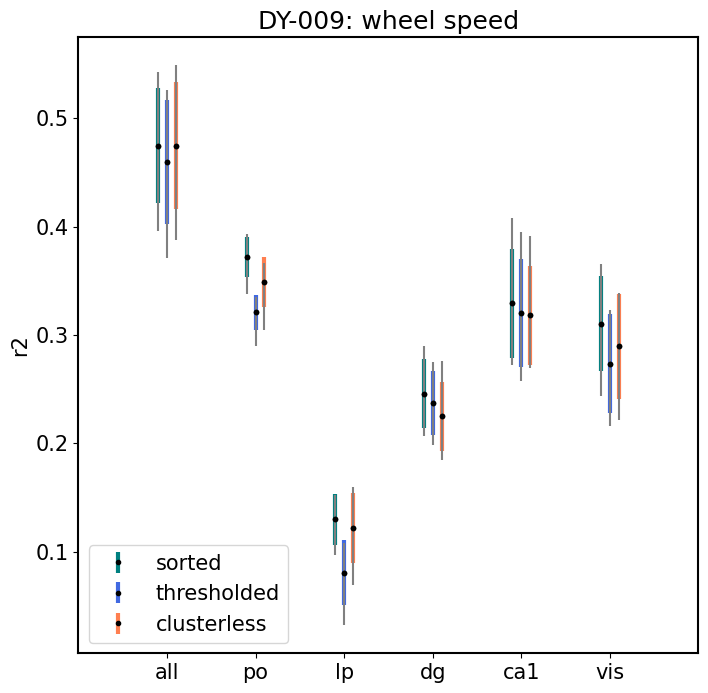

In [64]:
viz.plot_compare_decoder_barplots(
    save_path + '/kilosort_localizations/dynamic_behaviors',
    'wheel speed', 
    'r2', 
    rois, 
    n_folds=5, 
    add_smooth=False, 
    figure_size=(8,8), 
    font_size=15, 
    title='DY-009: wheel speed',
    save_fig=True,
    fig_path='../saved_figs/danlab/Subjects/DY_009',
)